In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import time
import torch
import numpy as np
import os

from scripts.model_builder import get_default_spec, save_model, load_model_only_inference
from scripts.transformer_prediction_interface import transformer_predict, get_params_from_config, TabPFNClassifier
from scripts.differentiable_pfn_evaluation import eval_model, eval_model_range
from scripts.model_builder import get_model, get_default_spec, save_model, load_model

from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids, test_dids_classification

from scripts import tabular_metrics
import random

In [3]:
base_path = '.'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load Datasets

In [4]:
max_samples = 10000
bptt = 10000

cc_test_datasets_multiclass, cc_test_datasets_multiclass_df = load_openml_list(open_cc_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = max_samples, num_feats=100, return_capped=True)
cc_valid_datasets_multiclass, cc_valid_datasets_multiclass_df = load_openml_list(open_cc_valid_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = max_samples, num_feats=100, return_capped=True)

# Loading longer OpenML Datasets for generalization experiments (optional)
# test_datasets_multiclass, test_datasets_multiclass_df = load_openml_list(test_dids_classification, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)

# Set the seed for the random number generator provided by PyTorch
torch.manual_seed(0)

# Set the seed for the random number generator provided by NumPy
np.random.seed(0)

random.seed(0)
random.shuffle(cc_valid_datasets_multiclass)

Number of datasets: 30
Loading balance-scale 11 ..
Loading mfeat-fourier 14 ..
Loading breast-w 15 ..
Loading mfeat-karhunen 16 ..
Loading mfeat-morphological 18 ..
Loading mfeat-zernike 22 ..
Loading cmc 23 ..
Loading credit-approval 29 ..
Loading credit-g 31 ..
Loading diabetes 37 ..
Loading tic-tac-toe 50 ..
Loading vehicle 54 ..
Loading eucalyptus 188 ..
Loading analcatdata_authorship 458 ..
Loading analcatdata_dmft 469 ..
Loading pc4 1049 ..
Loading pc3 1050 ..
Loading kc2 1063 ..
Loading pc1 1068 ..
Loading banknote-authentication 1462 ..
Loading blood-transfusion-service-center 1464 ..
Loading ilpd 1480 ..
Loading qsar-biodeg 1494 ..
Loading wdbc 1510 ..
Loading cylinder-bands 6332 ..
Loading dresses-sales 23381 ..
Loading MiceProtein 40966 ..
Loading car 40975 ..
Loading steel-plates-fault 40982 ..
Loading climate-model-simulation-crashes 40994 ..
Number of datasets: 150
Loading breast-cancer 13 ..
Loading colic 25 ..
Loading dermatology 35 ..
Loading sonar 40 ..
Loading glass 

In [5]:
def get_datasets(selector, task_type, suite='cc'):
    if task_type == 'binary':
        ds = valid_datasets_binary if selector == 'valid' else test_datasets_binary
    else:
        if suite == 'openml':
            ds = valid_datasets_multiclass if selector == 'valid' else test_datasets_multiclass
        elif suite == 'cc':
            ds = cc_valid_datasets_multiclass if selector == 'valid' else cc_test_datasets_multiclass
        else:
            raise Exception("Unknown suite")
    return ds

In [6]:
model_string, longer, task_type = '', 1, 'multiclass'
eval_positions = [1000]
bptt = 2000
    
test_datasets, valid_datasets = get_datasets('test', task_type, suite='cc'), get_datasets('valid', task_type, suite='cc')

# Pick single Dataset

In [7]:
evaluation_dataset_index = 8 # Index of the dataset to predict
ds = test_datasets[evaluation_dataset_index]
print(f'Evaluation dataset name: {ds[0]} shape {ds[1].shape}')

Evaluation dataset name: credit-g shape torch.Size([1000, 20])


## Split x and y in train and test

In [8]:
xs, ys = ds[1].clone(), ds[2].clone()
eval_position = xs.shape[0] // 2
train_xs, train_ys = xs[0:eval_position], ys[0:eval_position]
test_xs, test_ys = xs[eval_position:], ys[eval_position:]

## weighting for the ensemble (AUC/CE)

In [16]:
class PFNEnsemble:
    def __init__(self, 
                 model_storage_folders=["models_gp"],
                 device="cpu",
                 N_ensemble_configurations=5,
                 verbose=False):
        # Maps model_index to loaded model
        self.model_dict = {}
        self.data_ens_dict = {}
        
        for model_storage_folder in model_storage_folders:
            # Iterate over all files in the model_path directory
            for model_index, model_string in enumerate(os.listdir(model_storage_folder)):
                if model_string.endswith('.cpkt'):  # Assuming the models have a .cpkt extension
                    loaded_model = TabPFNClassifier(base_path=model_storage_folder,
                                                    model_string=model_string[:-5],
                                                    N_ensemble_configurations=N_ensemble_configurations,
                                                    batch_size_inference=1, 
                                                    no_preprocess_mode=True)
                    
        
                    self.model_dict[model_string.split('.')[0]] = {"model": loaded_model}

    def fit(self, train_xs, train_ys):
        for model_name, model_content in self.model_dict.items():
            model = model_content["model"]
            model.fit(train_xs, train_ys)
            
    def get_split_of_train_data_simple(self, train_x, train_y, split_share):
        temp_split_pos = int(train_x.shape[0] * split_share)
        
        temp_split_train_x = train_x[:temp_split_pos]
        temp_split_test_x = train_x[temp_split_pos:]
        
        temp_split_train_y = train_y[:temp_split_pos]
        temp_split_test_y = train_y[temp_split_pos:]
        return [(temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y)]
    
                
    def get_split_of_train_data_bagging(self, train_x, train_y, split_share, number_splits):
        splits = [] # each entry has format: [(temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y)]
        # todo repeat the following number_splits times and add each time to splits
        for i in range(number_splits):
            temp_split_indices = random.sample(range(len(train_x)), int(split_share * len(train_x)))
            temp_split_train_x = [train_x[i] for i in temp_split_indices]
            temp_split_test_x = [train_x[i] for i in range(len(train_x)) if i not in temp_split_indices]

            temp_split_train_y = [train_y[i] for i in temp_split_indices]
            temp_split_test_y = [train_y[i] for i in range(len(train_y)) if i not in temp_split_indices]
            splits.append((temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y))
        return splits
    
    
    def get_split_of_train_data_pasting(self, train_x, train_y, split_share):
        splits = [] # each entry has format: [(temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y)]
        # todo repeat the following number_splits times and add each time to splits
        list_of_indices_to_sample = list(range(len(train_x)))
        while len(list_of_indices_to_sample) > 1: # need at least two 
            len_list_to_sample = len(list_of_indices_to_sample)
            if len_list_to_sample <= int(split_share * len(train_x)) * 2:
                temp_split_train_indices = list_of_indices_to_sample[:len_list_to_sample//2]
                temp_split_test_indices = list_of_indices_to_sample[len_list_to_sample//2:]
            else:    
                temp_split_train_indices = random.sample(list_of_indices_to_sample, int(split_share * len(train_x)))
                remaining_list_indices = [x for x in list_of_indices_to_sample if x not in temp_split_train_indices]
                temp_split_test_indices = random.sample(remaining_list_indices,int(split_share * len(train_x)))
                
            # remove indices which has been sampled in temp_split_indices from list_of_indices_to_sample
            list_of_indices_to_sample  = [x for x in list_of_indices_to_sample if x not in temp_split_train_indices + temp_split_test_indices]

            temp_split_train_x = [train_x[i] for i in temp_split_train_indices]
            temp_split_test_x = [train_x[i] for i in temp_split_test_indices]

            temp_split_train_y = [train_y[i] for i in temp_split_train_indices]
            temp_split_test_y = [train_y[i] for i in temp_split_test_indices]

            splits.append((temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y))
        return splits
            
        
    def get_train_auc_of_model(self,model,splits): 
        total_auc = 0
        for temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y in splits:
            model.fit(temp_split_train_x, temp_split_train_y)
            prediction_ = model.predict_proba(temp_split_test_x)
            auc = tabular_metrics.auc_metric(temp_split_test_y, prediction_)
            total_auc += auc
        total_auc /= len(splits)
        return total_auc
        
    def compute_weights(self, level, weight_type):
        
        if weight_type == f"weighted_average":
            if level == 'data':
                sum_of_auc = {}
                for key in self.data_ens_dict.keys():
                    model_name = key.split('-')[0]
                    if model_name not in sum_of_auc.keys():
                        sum_of_auc[model_name] = 0
                    sum_of_auc[model_name] += self.data_ens_dict[key][f'{level}_auc']
                    
                for data_ens_key, data_ens_content in self.data_ens_dict.items():
                    self.data_ens_dict[data_ens_key][f"{level}_weight"] = data_ens_content[f"{level}_auc"] / sum_of_auc[data_ens_key.split('-')[0]]
                
            else: # model here
                sum_of_auc = sum([i[f'{level}_auc'] for i in self.model_dict.values()])

                for ensemble_index, model_name in self.model_dict.items():
                    self.model_dict[ensemble_index][f"{level}_weight"] = self.model_dict[ensemble_index][f"{level}_auc"] / sum_of_auc
                
        elif weight_type == f"best_performer":
            
            if level == 'data':
                max_aucs = {}
                for key in self.data_ens_dict.keys():
                    model_name = key.split('-')[0]
                    if model_name not in max_aucs.keys():
                        max_aucs[model_name] = self.data_ens_dict[key][f'{level}_auc']
                    max_aucs[model_name] = max(max_aucs[model_name], self.data_ens_dict[key][f'{level}_auc'])
                
                max_auc_keys = {}
                for data_ens_key, data_ens_content in self.data_ens_dict.items():
                    if data_ens_content[f'{level}_auc'] == max_aucs[data_ens_key.split('-')[0]]:
                        max_auc_keys[data_ens_key.split('-')[0]] = data_ens_key
                
                for data_ens_key in self.data_ens_dict.keys():
                    if data_ens_key in max_auc_keys.values():
                        self.data_ens_dict[data_ens_key][f'{level}_weight'] = 1
                    else:
                        self.data_ens_dict[data_ens_key][f'{level}_weight'] = 0
                
            else:
                max_model_auc = max([i[f'{level}_auc'] for i in self.model_dict.values()])
                
                max_auc_key = None
                for model_key, model_content in self.model_dict.items():
                    if model_content[f'{level}_auc'] == max_model_auc:
                        max_auc_key = model_key
                        break
                
                for model_key in self.model_dict.keys():
                    if model_key == max_auc_key:
                        self.model_dict[model_key][f'{level}_weight'] = 1
                    else:
                        self.model_dict[model_key][f'{level}_weight'] = 0

        
    def get_splits_of_train_data(self, full_train_x, full_train_y, split_type, split_share, number_splits):
        # compute the train data splits for later AUC computation
        if split_type == "simple":
            return self.get_split_of_train_data_simple(train_x=full_train_x, train_y=full_train_y, split_share=split_share)
        elif split_type == "bagging":
            return self.get_split_of_train_data_bagging(train_x=full_train_x, train_y=full_train_y, split_share=split_share,number_splits=number_splits)
        elif split_type == "pasting": 
            return self.get_split_of_train_data_pasting(train_x=full_train_x, train_y=full_train_y, split_share=split_share)
        else:
            print("todo raise error")
        
        
    def predict_proba(self, 
                      test_xs, 
                      data_ensemble_config = None,
                      model_ensemble_config = None,
                      data_preprocess_config = None, 
                      multiple_models=False,
                      pre_processing=False ):
        
         # ------------------- only preprocessing with one model --------------------------
        if multiple_models is False and pre_processing is True:
            print("predict_proba use only the baseline model and data-ensembling as no moe config is given! ")
            
            baseline_model, baseline_name = None, None
            
            for model_name, model_content in self.model_dict.items():
                if "baseline" in model_name:
                    baseline_model = model_content["model"]
                    baseline_name = model_name
                    break
    
            if baseline_model is None:  
                raise NotImplementedError(f'The baseline_model could not be found for predict proba.')

            train_xs, train_ys = baseline_model.X_, baseline_model.y_
            
            # add identity
            data_preprocess_config['sklearn_transformations']['identity'] = None
            
            # APPLY DATA PREPROCESSING / AUGMENTATION
            for transformer_name, transformer in data_preprocess_config["sklearn_transformations"]:
                transformation_key = baseline_name + '-' + transformer_name
                self.data_ens_dict[transformation_key] = {}
                
                if transformer_name != 'identity':
                    train_xs_t = transformer.fit_transform(train_xs)
                    test_xs_t = transformer.transform(test_xs)
                else:
                    train_xs_t = train_xs
                    test_xs_t = test_xs
                
                self.data_ens_dict[transformation_key]['train_data'] = (train_xs_t, train_ys)
                self.data_ens_dict[transformation_key]['test_data'] = test_xs_t
                
                splits = self.get_splits_of_train_data(full_train_x=train_xs_t,
                                                       full_train_y=train_ys,
                                                       split_type=data_ensemble_config["data_split_type"], 
                                                       split_share=data_ensemble_config["data_split_share"],
                                                       number_splits=data_ensemble_config["data_number_splits"])

                # Compute AUC performance of train data
                self.data_ens_dict[transformation_key]['data_auc'] = float(self.get_train_auc_of_model(model=baseline_model,
                                                                                               splits=splits))
                baseline_model.fit(train_xs_t, train_ys)
                self.data_ens_dict[transformation_key]['test_preds'] = baseline_model.predict_proba(self.data_ens_dict[transformation_key]['test_data'])
                
            # pop identity from transformation list
            data_preprocess_config['sklearn_transformations'].pop('identity')
            
            
            baseline_model.fit(train_xs, train_ys)
            # after having collected the auc / ce /... scores of the models of the train set, we want to 
            # compute the weights for the final forward pass
            self.compute_weights(level="data",
                                 weight_type=data_ensemble_config["data_weight_type"])
            
            prediction_weighted = 0
            for data_ens_key, data_ens_content in self.data_ens_dict.items():
                prediction_weighted += torch.tensor(data_ens_content['test_preds']) * data_ens_content['data_weight']
                
            # Storing the weighted predictions as predictions of the model as well
            self.model_dict[baseline_name]['test_preds'] = prediction_weighted
            
            return prediction_weighted

            
        # ------------------------- only model ensembling ----------------------------------------
        elif multiple_models is True and pre_processing is False:
            print("predict_proba use moe ensembling and no data-ensembling as no data preprocessing is given")
            
            for model_name, model_content in self.model_dict.items():
                
                train_xs, train_ys = model_content['model'].X_, model_content['model'].y_
                
                # compute the train data splits for later AUC computation
                splits = self.get_splits_of_train_data(full_train_x=train_xs,
                                                       full_train_y=train_ys,
                                                       split_type=model_ensemble_config["model_split_type"], 
                                                       split_share=model_ensemble_config["model_split_share"],
                                                       number_splits=model_ensemble_config["model_number_splits"])

                # Compute AUC performance of train data 
                self.model_dict[model_name]['model_auc'] = float(self.get_train_auc_ce_of_model(model=model_content['model'],
                                                                                                splits=splits))

                self.model_dict[model_name]['model'].fit(train_xs, train_ys) # overwrite the training data in the model again!
                model_content['test_preds'] = model_content['model'].predict_proba(test_xs)
            
            # after having collected the auc scores of the models of the train set, we want to compute the weights for the final forward pass
            self.compute_weights(level="model",
                                 weight_type=model_ensemble_config["model_weight_type"])
            
            prediction_weighted = 0
            for model_name, model_content in self.model_dict.items():
                prediction_weighted += torch.tensor(model_content['test_preds']) * model_content['model_weight']
                          
            return prediction_weighted
        
        
        # ---------------------- both datapreprocessing for each in moe ensembling ------------------------------    
        else: 
            print("data preprocessing and moe both used!" )
            
            for model_name, model_content in self.model_dict.items():
                    
                train_xs, train_ys = model_content['model'].X_, model_content['model'].y_

                # add identity
                data_preprocess_config['sklearn_transformations']['identity'] = None

                # APPLY DATA PREPROCESSING / AUGMENTATION
                for transformer_name, transformer in data_preprocess_config["sklearn_transformations"]:
                    transformation_key = model_name + '-' + transformer_name
                    self.data_ens_dict[transformation_key] = {}

                    if transformer_name != 'identity':
                        train_xs_t = transformer.fit_transform(train_xs)
                        test_xs_t = transformer.transform(test_xs)
                    else:
                        train_xs_t = train_xs
                        test_xs_t = test_xs

                    self.data_ens_dict[transformation_key]['train_data'] = (train_xs_t, train_ys)
                    self.data_ens_dict[transformation_key]['test_data'] = test_xs_t

                    splits = self.get_splits_of_train_data(full_train_x=train_xs_t,
                                                           full_train_y=train_ys,
                                                           split_type=data_ensemble_config["data_split_type"], 
                                                           split_share=data_ensemble_config["data_split_share"],
                                                           number_splits=data_ensemble_config["data_number_splits"])

                    # Compute AUC performance of train data
                    self.data_ens_dict[transformation_key]['data_auc'] = float(self.get_train_auc_of_model(model=baseline_model,
                                                                                                   splits=splits))
                    model_content['model'].fit(train_xs_t, train_ys)
                    self.data_ens_dict[transformation_key]['test_preds'] = model_content['model'].predict_proba(self.data_ens_dict[transformation_key]['test_data'])

                # pop identity from transformation list
                data_preprocess_config['sklearn_transformations'].pop('identity')

                model_content['model'].fit(train_xs, train_ys)
                # after having collected the auc scores of the models of the train set, we want to 
            
            # compute the weights for the data ensembles
            self.compute_weights(level="data",
                                 weight_type=data_ensemble_config["data_weight_type"])
            
            
            for model_name in self.model_dict.keys():
                model_prediction_weighted = 0
                model_auc_weighted = 0
                for data_ens_name, data_ens_content in self.data_ens_dict.items():
                    if data_ens_name.split('-')[0] == model_name:
                        model_prediction_weighted += torch.tensor(data_ens_content['test_preds']) * \
                                                                                    data_ens_content['data_weight']
                        model_auc_weighted += torch.tensor(data_ens_content['data_auc']) * \
                                                                                    data_ens_content['data_weight']
                self.model_dict[model_name]['test_preds'] = model_prediction_weighted
                self.model_dict[model_name]['model_auc'] = model_auc_weighted
            
            # compute the weights for the final model ensemble
            self.compute_weights(level="model",
                                 weight_type=model_ensemble_config["model_weight_type"])
            
            prediction_weighted = 0
            for model_name, model_content in self.model_dict.items():
                prediction_weighted += torch.tensor(model_content['test_preds']) * model_content['model_weight']

            return prediction_weighted

In [14]:
country_capitals = {
  "United States": {"Washington D.C.":'capital'}, 
  "Italy": {"Rome": None}, 
  "England": {"London": 'capital'}
}


for key, val in country_capitals.items():
    if key == "United States":
        val["sample"] = 'test'

## Ensemble with MOE Approach


In [34]:
import traceback
import time

model_paths = ["./models_gp","./models_causal","./baseline"]    
    
classifier_tabpfn = TabPFNClassifier(device=device, 
                                     base_path="./baseline",
                                     model_string="downloaded_tabpfn",
                                     N_ensemble_configurations=1,
                                     batch_size_inference=1, 
                                     no_preprocess_mode=True)

weighting_metrics = ["model_auc"]
weight_types = ["model_best_performer","model_weighted_average"]# ["weighted_average", "best_performer"]
split_types =["model_simple", "model_bagging", "model_pasting"]# ["simple", "bagging", "pasting"]


results = {}
best_performers = []

start = 0
end =  5
number_iterations = range(max(start, 0),min(end,len(test_datasets)))# Index of the dataset to predict

for evaluation_dataset_index in number_iterations:
    
    ds = test_datasets[evaluation_dataset_index]
    print(f'Evaluation dataset name: {ds[0]} shape {ds[1].shape} --- {evaluation_dataset_index}/{len(test_datasets)}')

    xs, ys = ds[1].clone(), ds[2].clone()
    #-----------------------------
    xs = torch.where(torch.isnan(xs), torch.tensor(0.0), xs)
    ys = torch.where(torch.isnan(ys), torch.tensor(0), ys.long())
    #-----------------------------
    eval_position = xs.shape[0] // 2
    train_xs, train_ys = xs[0:eval_position], ys[0:eval_position]
    test_xs, test_ys = xs[eval_position:], ys[eval_position:]
    
    # compare to normal tabpfn
    classifier_tabpfn.fit(train_xs, train_ys)
    prediction_tabpfn = classifier_tabpfn.predict_proba(test_xs)
    auc_tabpfn, ce_tabpfn = tabular_metrics.auc_metric(test_ys, prediction_tabpfn), tabular_metrics.cross_entropy(test_ys, prediction_tabpfn)
    
    # add computed results to result dict
    if "tabpfn" not in results:
        results["tabpfn"] = {}
        results["tabpfn"]["auc"] = np.zeros(len(number_iterations))
        
    results["tabpfn"]["auc"][evaluation_dataset_index - start] = auc_tabpfn.item()

    # MoE Configurations ---------------------
    for weighting_metric in weighting_metrics: 
        for weight_type in weight_types: 
            for split_type in split_types:
                print(f"Current configuration: weighting_metric {weighting_metric}, weight_type {weight_type}, split_type {split_type}")
                # --------------------------------
                
                model_ensemble_config = {"model_weighting_metric":weighting_metric,
                                         "model_weight_type":weight_type,
                                         "model_split_type":split_type,
                                         "model_split_share":0.5, 
                                         "model_number_splits": 5}
                
                data_preprocess_config = None
                
                # create classifier with configuration 
                classifier_ensemble = PFNEnsemble(model_storage_folders=model_paths,
                                                  N_ensemble_configurations=1,
                                                  device=device)

                start_time = time.time()
                classifier_ensemble.fit(train_xs, train_ys)
                prediction_ = classifier_ensemble.predict_proba(test_xs,
                                                                data_ensemble_config=data_ensemble_config,
                                                                model_ensemble_config=model_ensemble_config,
                                                                data_preprocess_config=data_preprocess_config, 
                                                                multiple_models=True,
                                                                pre_processing=False)
                
                auc_ensemble, ce_ensemble = tabular_metrics.auc_metric(test_ys, prediction_), tabular_metrics.cross_entropy(test_ys, prediction_)
                
                # add computed results to results dict
                key_name = f"ensemble_{weighting_metric}_{weight_type}_{split_type}"
                if key_name not in results:
                    results[key_name] = {}
                    results[key_name]["auc"] = np.zeros(len(number_iterations))
                results[key_name]["auc"][evaluation_dataset_index - start] = auc_ensemble.item()  

Evaluation dataset name: balance-scale shape torch.Size([625, 4]) --- 0/30
Current configuration: weighting_metric model_auc, weight_type model_best_performer, split_type model_simple
predict_proba use moe ensembling and no data-ensembling as no data preprocessing is given
Current configuration: weighting_metric model_auc, weight_type model_best_performer, split_type model_bagging
predict_proba use moe ensembling and no data-ensembling as no data preprocessing is given
Current configuration: weighting_metric model_auc, weight_type model_best_performer, split_type model_pasting
predict_proba use moe ensembling and no data-ensembling as no data preprocessing is given
Current configuration: weighting_metric model_auc, weight_type model_weighted_average, split_type model_simple
predict_proba use moe ensembling and no data-ensembling as no data preprocessing is given
Current configuration: weighting_metric model_auc, weight_type model_weighted_average, split_type model_bagging
predict_proba

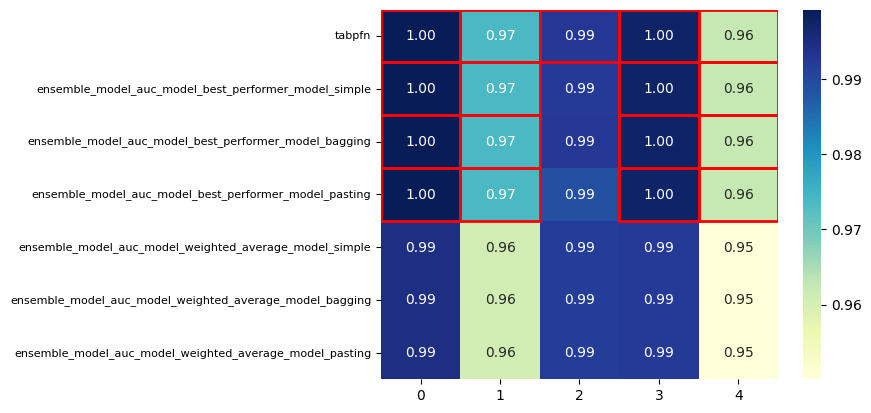

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_rel

baseline_model = 'tabpfn'

# Convert the dictionary to a DataFrame
df_data = {model_name: model_metrics['auc'] for model_name, model_metrics in results.items()}
df = pd.DataFrame.from_dict(df_data, orient="index")

# Create the heatmap
ax = sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

# Find the maximum value in each column
max_values = df.max(axis=0)

# Add rectangles for the best performing model in each dataset
for col in range(df.shape[1]):
    highest_indices = np.where(df.iloc[:, col] == max_values[col])[0]
    for row in highest_indices:
        ax.add_patch(plt.Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))

        model_name = df.index[row]
        if model_name != baseline_model:
            baseline_auc = results[baseline_model]['auc']
            model_auc = results[model_name]['auc']
            t_statistic, p_value = ttest_rel(baseline_auc, model_auc)
            if p_value < 0.05:
                ax.text(col + 0.5, row + 0.5, '*', color='red', fontsize=12, ha='center', va='center')
                print(f"significant: {model_name}")

plt.show()  # Show the plot

In [37]:
import numpy as np
from scipy.stats import ttest_rel

baseline_model = 'tabpfn'
baseline_auc = results[baseline_model]['auc']

for model_name, model_metrics in results.items():
    if model_name == baseline_model:
        continue

    model_auc = model_metrics['auc']
    
    # Perform paired t-test on aggregated auc values
    t_statistic, p_value = ttest_rel(np.hstack(baseline_auc), np.hstack(model_auc))
    
    # Check if the p-value is below a significance threshold (e.g., 0.05)
    if p_value < 0.05:
        print(f"{model_name} is significantly better performing than {baseline_model} across all datasets.")
    else:
        pass
        #print(f"{model_name} is not significantly better performing than {baseline_model} across all datasets.")


ensemble_model_auc_model_weighted_average_model_simple is significantly better performing than tabpfn across all datasets.
ensemble_model_auc_model_weighted_average_model_bagging is significantly better performing than tabpfn across all datasets.
ensemble_model_auc_model_weighted_average_model_pasting is significantly better performing than tabpfn across all datasets.


## Ensemble with ONLY Data Preprocessing Approach


In [36]:
import traceback
import time
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
import traceback

model_paths = ["./baseline"]

classifier_tabpfn = TabPFNClassifier(device=device, 
                                     base_path="./baseline",
                                     model_string="model_bag_baseline",
                                     N_ensemble_configurations=1,
                                     batch_size_inference=1,
                                     no_preprocess_mode=True,
                                     multiclass_decoder='permutation',
                                     feature_shift_decoder=False)#??? 

weighting_metrics = ["data_auc"]
weight_types = ["best_performer","weighted_average"]# ["weighted_average", "best_performer"]
split_types =["simple"]# ["simple", "bagging", "pasting"]


results = {}
best_performers = []

# Indices of the datasets to predict
start = 10
end =  12
number_iterations = range(max(start, 0),min(end,len(test_datasets)))

for evaluation_dataset_index in number_iterations:
    ds = test_datasets[evaluation_dataset_index]
    print(f'Evaluation dataset name: {ds[0]} shape {ds[1].shape} --- {evaluation_dataset_index}/{len(test_datasets)}')

    xs, ys = ds[1].clone(), ds[2].clone()
    #-----------------------------
    xs = torch.where(torch.isnan(xs), torch.tensor(0.0), xs)
    ys = torch.where(torch.isnan(ys), torch.tensor(0), ys.long())
    #-----------------------------
    eval_position = xs.shape[0] // 2
    train_xs, train_ys = xs[0:eval_position], ys[0:eval_position]
    test_xs, test_ys = xs[eval_position:], ys[eval_position:]
    
    # compare to normal tabpfn
    
    classifier_tabpfn.fit(train_xs, train_ys)
    prediction_tabpfn = classifier_tabpfn.predict_proba(test_xs)
    auc_tabpfn = tabular_metrics.auc_metric(test_ys, prediction_tabpfn)
    
    # add computed results to result dict
    if "tabpfn" not in results:
        results["tabpfn"] = {}
        results["tabpfn"]["auc"] = np.zeros(len(number_iterations))
    results["tabpfn"]["auc"][evaluation_dataset_index - start] = auc_tabpfn.item()
        
    # MoE Configurations ---------------------
    for weighting_metric in weighting_metrics: 
        for weight_type in weight_types: 
            for split_type in split_types:
                print()
                print(f"Current configuration: weighting_metric {weighting_metric}, weight_type {weight_type}, split_type {split_type}")
                # --------------------------------
                data_ensemble_config = {"data_weighting_metric":weighting_metric,
                                        "data_weight_type":weight_type,
                                        "data_split_type":split_type,
                                        "data_split_share":0.5, 
                                        "data_number_splits": 3}
                
                data_preprocess_config = {"N_ensemble_configurations": 1,
                                          "sklearn_transformations": [("PowerTransformer",PowerTransformer()),
                                                                      ("QuantileTransformer",QuantileTransformer())] } 
                
                # create classifier with configuration 
                classifier_ensemble = PFNEnsemble(model_storage_folders=model_paths,
                                                  N_ensemble_configurations=data_preprocess_config["N_ensemble_configurations"],
                                                  device=device)

                classifier_ensemble.fit(train_xs, train_ys)
                prediction_ = classifier_ensemble.predict_proba(test_xs,
                                                                model_ensemble_config= None,
                                                                data_ensemble_config=data_ensemble_config,
                                                                data_preprocess_config=data_preprocess_config,
                                                                multiple_models=False,
                                                                pre_processing=True )
                
                auc_ensemble  = tabular_metrics.auc_metric(test_ys, prediction_)
                
                # add computed results to results dict
                key_name = f"ensemble_{weighting_metric}_{weight_type}_{split_type}"
                
                if key_name not in results:
                    results[key_name] = {}
                    results[key_name]["auc"] = np.zeros(len(number_iterations))
                    
                results[key_name]["auc"][evaluation_dataset_index - start] = auc_ensemble.item() 

Evaluation dataset name: tic-tac-toe shape torch.Size([958, 9]) --- 10/30

Current configuration: weighting_metric data_auc, weight_type best_performer, split_type simple
predict_proba use only the baseline model and data-ensembling as no moe config is given! 


C:\Users\draco\miniconda3\envs\lab_env\lib\site-packages\sklearn\preprocessing\_data.py:2615: UserWarning: n_quantiles (1000) is greater than the total number of samples (479). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


{'model_bag_baseline': 0.8766844647851513}
{'model_bag_baseline': 'model_bag_baseline-QuantileTransformer'}
[(0.8438850750063565, 0), (0.8553267226036105, 0), (0.8766844647851513, 1)]

Current configuration: weighting_metric data_auc, weight_type weighted_average, split_type simple
predict_proba use only the baseline model and data-ensembling as no moe config is given! 


C:\Users\draco\miniconda3\envs\lab_env\lib\site-packages\sklearn\preprocessing\_data.py:2615: UserWarning: n_quantiles (1000) is greater than the total number of samples (479). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


[(0.8438850750063565, 0.3276083308656598), (0.8553267226036105, 0.3320501431250617), (0.8766844647851513, 0.3403415260092784)]
Evaluation dataset name: vehicle shape torch.Size([846, 18]) --- 11/30

Current configuration: weighting_metric data_auc, weight_type best_performer, split_type simple
predict_proba use only the baseline model and data-ensembling as no moe config is given! 


C:\Users\draco\miniconda3\envs\lab_env\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\draco\miniconda3\envs\lab_env\lib\site-packages\numpy\core\_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
C:\Users\draco\miniconda3\envs\lab_env\lib\site-packages\sklearn\preprocessing\_data.py:2615: UserWarning: n_quantiles (1000) is greater than the total number of samples (423). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


{'model_bag_baseline': 0.9340667043108876}
{'model_bag_baseline': 'model_bag_baseline-QuantileTransformer'}
[(0.9325478558850763, 0), (0.9334687677851105, 0), (0.9340667043108876, 1)]

Current configuration: weighting_metric data_auc, weight_type weighted_average, split_type simple
predict_proba use only the baseline model and data-ensembling as no moe config is given! 


C:\Users\draco\miniconda3\envs\lab_env\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\draco\miniconda3\envs\lab_env\lib\site-packages\numpy\core\_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
C:\Users\draco\miniconda3\envs\lab_env\lib\site-packages\sklearn\preprocessing\_data.py:2615: UserWarning: n_quantiles (1000) is greater than the total number of samples (423). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


[(0.9325478558850763, 0.3330428943189577), (0.9334687677851105, 0.33337178163842834), (0.9340667043108876, 0.333585324042614)]


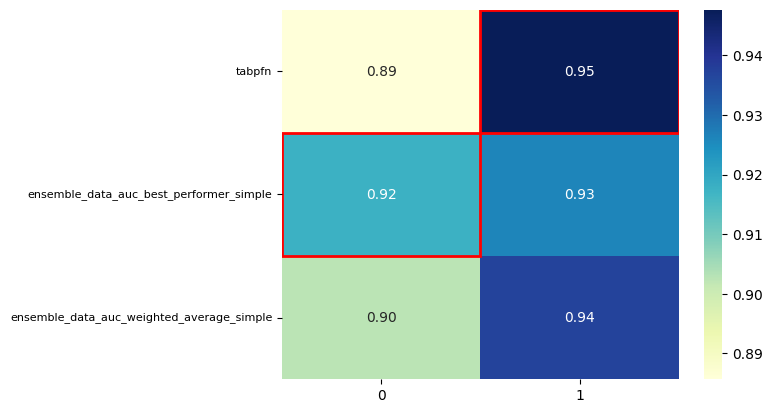

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
baseline_model = 'tabpfn'

# Convert the dictionary to a DataFrame
df_data = {model_name: model_metrics['auc'] for model_name, model_metrics in results.items()}
df = pd.DataFrame.from_dict(df_data, orient="index")

# Create the heatmap
ax = sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

# Find the maximum value in each column
max_values = df.max(axis=0)

# Add rectangles for the best performing model in each dataset
for col in range(df.shape[1]):
    highest_indices = np.where(df.iloc[:, col] == max_values[col])[0]
    for row in highest_indices:
        ax.add_patch(plt.Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))

        model_name = df.index[row]
        if model_name != baseline_model:
            baseline_auc = results[baseline_model]['auc']
            model_auc = results[model_name]['auc']
            t_statistic, p_value = ttest_rel(model_auc, baseline_auc, alternative='greater')
            if p_value < 0.05:
                ax.text(col + 0.5, row + 0.5, '*', color='red', fontsize=12, ha='center', va='center')
                print(f"significant: {model_name}")

plt.show()  # Show the plot

In [22]:
import numpy as np
from scipy.stats import ttest_rel

baseline_model = 'tabpfn'
baseline_auc = results[baseline_model]['auc']

for model_name, model_metrics in results.items():
    if model_name == baseline_model:
        continue

    model_auc = model_metrics['auc']
    
    # Perform paired t-test on aggregated auc values
    t_statistic, p_value = ttest_rel(np.hstack(baseline_auc), np.hstack(model_auc))
    
    # Check if the p-value is below a significance threshold (e.g., 0.05)
    
    print(p_value)
        print(f"{model_name} is significantly better performing than {baseline_model} across all datasets.")
    else:
        pass
        #print(f"{model_name} is not significantly better performing than {baseline_model} across all datasets.")


0.2504492931462494
0.2504492931462494
0.2504492931462494
0.25029597848757784
0.2504492931462494
0.25029597848757784
0.2504492931462494
0.2504492931462494
0.2504492931462494
0.2504492931462494
0.25034398021423465
0.2504492931462494


# Combined Data and Expert Ensembling

In [52]:
import traceback
import time
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
model_paths = ["./models_gp","./models_causal","./baseline"]    

classifier_tabpfn = TabPFNClassifier(device=device, 
                                     base_path="./baseline",
                                     model_string="downloaded_tabpfn",
                                     N_ensemble_configurations=1,
                                     batch_size_inference=1, 
                                     no_preprocess_mode=True,
                                     multiclass_decoder='permutation',
                                     feature_shift_decoder=False)#??? 

data_weighting_metrics = ["data_auc"]  
data_weight_types = ["data_best_performer","data_weighted_average"] 
data_split_types =["data_simple", "data_bagging", "data_pasting"] 

model_weighting_metrics = ["model_auc"]  
model_weight_types = ["model_best_performer","model_weighted_average"] 
model_split_types =["model_simple", "model_bagging", "model_pasting"] 


results = {}
best_performers = []

start = 10
end =  12
number_iterations = range(max(start, 0),min(end,len(test_datasets)))# Index of the dataset to predict

for evaluation_dataset_index in number_iterations:
    ds = test_datasets[evaluation_dataset_index]
    print(f'Evaluation dataset name: {ds[0]} shape {ds[1].shape} --- {evaluation_dataset_index}/{len(test_datasets)}')

    xs, ys = ds[1].clone(), ds[2].clone()
    #-----------------------------
    xs = torch.where(torch.isnan(xs), torch.tensor(0.0), xs)
    ys = torch.where(torch.isnan(ys), torch.tensor(0), ys.long())
    #-----------------------------
    eval_position = xs.shape[0] // 2
    train_xs, train_ys = xs[0:eval_position], ys[0:eval_position]
    test_xs, test_ys = xs[eval_position:], ys[eval_position:]
    
    # compare to normal tabpfn
 
    classifier_tabpfn.fit(train_xs, train_ys)
    prediction_tabpfn = classifier_tabpfn.predict_proba(test_xs)
    auc_tabpfn = float(tabular_metrics.auc_metric(test_ys, prediction_tabpfn))
    
    # add computed results to result dict
    if "tabpfn" not in results:
        results["tabpfn"] = {}
        results["tabpfn"]["auc"] = np.zeros(len(number_iterations))
    results["tabpfn"]["auc"][evaluation_dataset_index - start] = auc_tabpfn
        
    # MoE Configurations ---------------------
    for model_weighting_metric in model_weighting_metrics: 
        for model_weight_type in model_weight_types: 
            for model_split_type in model_split_types:
                print(f"Current model_configuration: model_weighting_metric {model_weighting_metric}, model_weight_type {model_weight_type}, model_split_type {model_split_type}")
                # --------------------------------
                model_ensemble_config = {"model_weighting_metric":model_weighting_metric,
                                         "model_weight_type":model_weight_type,
                                         "model_split_type":model_split_type,
                                         "model_split_share":0.5, 
                                         "model_number_splits": 5}
                
                data_preprocess_config = {"N_ensemble_configurations": 5,
                                          "sklearn_transformations": [("PowerTransformer",PowerTransformer()),
                                                                      ("QuantileTransformer",QuantileTransformer())]} 
                
                # create classifier with configuration 
                classifier_ensemble = PFNEnsemble(model_storage_folders=model_paths,
                                           N_ensemble_configurations=data_preprocess_config["N_ensemble_configurations"],
                                           device=device)
                
                for data_weighting_metric in data_weighting_metrics: 
                        for data_weight_type in data_weight_types: 
                            for data_split_type in data_split_types:
                                
                                data_ensemble_config = {"data_weighting_metric":data_weighting_metric,
                                                        "data_weight_type":data_weight_type,
                                                        "data_split_type":data_split_type,
                                                        "data_split_share":0.5, 
                                                        "data_number_splits": 5}
                
                                classifier_ensemble.fit(train_xs, train_ys)
                                prediction_ = classifier_ensemble.predict_proba(test_xs,
                                                                                model_ensemble_config=model_ensemble_config,
                                                                                data_ensemble_config=data_ensemble_config,
                                                                                data_preprocess_config=data_preprocess_config,
                                                                                multiple_models=True,
                                                                                pre_processing=True)
                        
                                auc_ensemble = tabular_metrics.auc_metric(test_ys, prediction_)
                            
                                # add computed results to results dict
                                key_name = f"ensemble_{weighting_metric}_{weight_type}_{split_type}"
                                if key_name not in results:
                                    results[key_name] = {}
                                    results[key_name]["auc"] = np.zeros(len(number_iterations))
                                results[key_name]["auc"][evaluation_dataset_index - start] = auc_ensemble 

Evaluation dataset name: tic-tac-toe shape torch.Size([958, 9]) --- 10/30
Current model_configuration: model_weighting_metric model_auc, model_weight_type model_best_performer, model_split_type model_simple
TODO data preprocessing and moe both used!
aug_weights_dict: {'PowerTransformer': {'data_auc': 0.8840579710144927, 'data_weight': 0}, 'QuantileTransformer': {'data_auc': 0.9199932197643867, 'data_weight': 1}, 'identity': {'data_auc': 0.8629544876684465, 'data_weight': 0}}
aug_weights_dict: {'PowerTransformer': {'data_auc': 0.8766844647851513, 'data_weight': 0}, 'QuantileTransformer': {'data_auc': 0.9058394779218578, 'data_weight': 1}, 'identity': {'data_auc': 0.8594796169166878, 'data_weight': 0}}


KeyboardInterrupt: 